In [1]:
import sys
sys.path.append("../")

In [2]:
from agents.matchmanager import MatchManager

from itertools import product

from agents import GreedyAgent, AlphaBetaAgent, RandomAgent
from scenarios import scenarioJunction, scenarioJunctionExo, scenarioTest1v1, scenarioTest2v2
from core.const import RED, BLUE
import json
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import confusion_matrix



In [3]:
def createDf(output):
    agents = ['RandomAgent','RegressorAgent','ClassifierAgent','GreedyAgent','RegressorMultiAgent']
    scenarios = ['Junction']
    all_json=[]
    for i in range(1000):
        for s in scenarios:
            for agentRed, agentBlue in product(agents, agents):
                file_name=f'../{output}/{agentRed}_{agentBlue}_{s}_{i}.json'
                data=json.load(open(file_name))
                all_json.append(data)  
    df=pd.DataFrame(all_json)
    return df

In [4]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                         ax=None):



    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])




    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories,ax=ax)
    #sns.set(font_scale=2.5)

    if xyplotlabels:
        ax.set_ylabel('Winner')
        ax.set_xlabel('Max score')
    
    if title:
        ax.set_title(title)

In [5]:
def confusionMatrix(df):
    agents = ['RandomAgent','RegressorAgent','ClassifierAgent','GreedyAgent','RegressorMultiAgent']
    fig_c, axs = plt.subplots(ncols=len(agents),nrows=len(agents),figsize=(20,10))
    for i,name in enumerate(agents):
        labels = ['True Neg','False Pos','False Neg','True Pos']
        categories = df['winner'].unique()
        for n in range(len(agents)):
            df_plot=df.loc[((df['teamRed'] == name)&(df['teamBlue'] == agents[n]))].copy()
            y_win=df_plot['winner'].values
            y_score = df_plot['playerWithMaxScore'].values
            cf_matrix = confusion_matrix(y_win, y_score)
            make_confusion_matrix(cf_matrix,categories=categories, title=f'{name} vs {agents[n]}',ax=axs[i][n])
    fig_c.tight_layout()    

In [6]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("white", "black"),
                     threshold=None, **textkw):



    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [7]:
def makeHeatmap(df):
    agents = ['RandomAgent','RegressorAgent','ClassifierAgent','GreedyAgent','RegressorMultiAgent']
    listoflist=[]
    for a in agents:
        win=[]
        for i in agents:
            df_b=df.loc[((df['teamRed'] == a)&(df['teamBlue'] == i))].copy()
            count_winner=df_b[df_b['winner']=='red'].count()['winner']
            win.append(count_winner/len(df_b))
        listoflist.append(win)
    fig, ax = plt.subplots(figsize=(10,5))

    im, cbar = heatmap(np.array(listoflist), agents, agents, ax=ax,cmap="bwr", cbarlabel="winner [red/total]")
    texts = annotate_heatmap(im, valfmt="{x:.2f}%")

    fig.tight_layout()
    #plt.show()

        
    

In [8]:
dfAll=createDf("output")



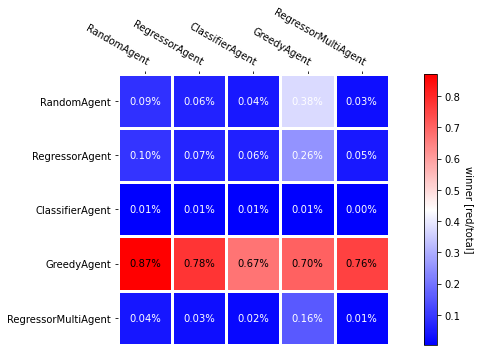

In [9]:
makeHeatmap(dfAll)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


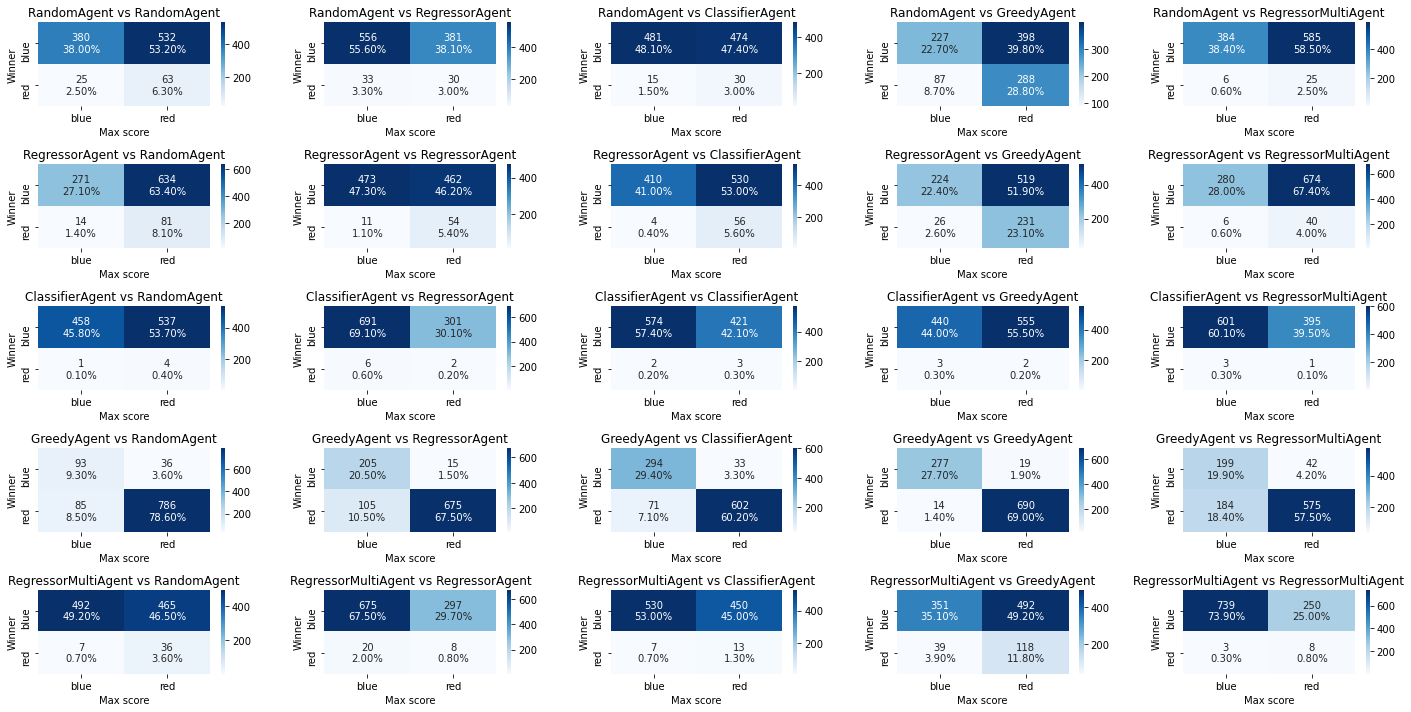

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [10]:
confusionMatrix(dfAll)

def agentVSagentColor(df,agent1,agent2,coloragent1):
    print("AGENTE VS AGENTE PER COLORE")
    if (coloragent1=="red"):
        mask=df.loc[((df.teamRed == agent1) & (df.teamBlue == agent2))]
        print(f'Percentage {agent1} Red on {agent2} Blue:',len(mask[mask['winner']==coloragent1])/len(mask))
        title=f'Percentage {agent1} Red on {agent2} Blue on scenario '
    else:
        mask=df.loc[((df.teamRed == agent2) & (df.teamBlue == agent1))]
        print(f'Percentage {agent1} Blue on {agent2} Red:',len(mask[mask['winner']==coloragent1])/len(mask))
        title=f'Percentage {agent1} Blue on {agent2} Red on scenario '

        
    departments=mask['scenario'].unique()

    fig, ax = plt.subplots(ncols=len(departments),nrows=1, figsize=(16,8))
    for i,name in enumerate(departments):
        dd=mask[(mask.scenario == name)]
        sns.barplot(y=((dd['winner'].value_counts())/len(dd))*100,x=dd['winner'].unique() ,ax=ax)
        ax.set_ylabel('Percentuale vittoria')
        ax.set(ylim=(0, 100))
        #print(title,name,len(dd[dd['winner']==coloragent1])/len(dd))
        title=f'Scenario->{name}. Agent red {agent1} and agent blue {agent2}'
        ax.set_title(title, fontsize=10)
        print(title,name,len(dd[dd['winner']==coloragent1])/len(dd))

    plt.plot() 
    #metti perncetuale per ogni scenario



def agentVSagentMoreScenario(df,agent1,agent2):
    print("AGENTE VS AGENTE")
    mask=df.loc[((df.teamRed == agent1) & (df.teamBlue == agent2))|((df.teamRed == agent2) & (df.teamBlue == agent1))]
    #mask['winnerAgent'].value_counts().plot.bar(title=f'Vincita {agent1} on {agent2}')
    print(f'Percentage {agent1} on {agent2}:',len(mask[mask['winnerAgent']==agent1])/len(mask))
    departments=mask['scenario'].unique()

    fig, ax = plt.subplots(ncols=len(departments),nrows=1, figsize=(16,8))
    for i,name in enumerate(departments):
        dd=mask[(mask.scenario == name)]
        #devi fare groupby su colonna winner, poi fai il count e dividi sul totale
        sns.barplot(y=((dd['winnerAgent'].value_counts())/len(dd))*100,x=dd['winnerAgent'].unique() ,ax=ax[i])
        ax[i].set_ylabel('Percentuale vittoria')
        ax[i].set(ylim=(0, 100))
        ax[i].set_title('scenario - {}'.format(name), fontsize=10)
        print(f'Percentage {agent1} on {agent2} on scenario {name}:',len(dd[dd['winnerAgent']==agent1])/len(dd))

    plt.plot() 
    #plotta percentuali-> fai solo scenario junction (nel caso junctionexo)


def agentVSagent(df,agent1,agent2):
    print("AGENT VS AGENT")
    mask=df.loc[((df.teamRed == agent1) & (df.teamBlue == agent2))|((df.teamRed == agent2) & (df.teamBlue == agent1))]
    #mask['winnerAgent'].value_counts().plot.bar(title=f'Vincita {agent1} on {agent2}')
    print(f'Percentage {agent1} on {agent2}:',len(mask[mask['winnerAgent']==agent1])/len(mask))
    departments=mask['scenario'].unique()

    fig, ax = plt.subplots(ncols=len(departments),nrows=1, figsize=(16,8))
    for i,name in enumerate(departments):
        dd=mask[(mask.scenario == name)]
        #devi fare groupby su colonna winner, poi fai il count e dividi sul totale
        sns.barplot(y=((dd['winnerAgent'].value_counts())/len(dd))*100,x=dd['winnerAgent'].unique() ,ax=ax)
        ax.set_ylabel('Percentuale vittoria')
        ax.set(ylim=(0, 100))
        ax.set_title('scenario - {}'.format(name), fontsize=10)
        #print(f'Percentage {agent1} on {agent2} on scenario {name}:',len(dd[dd['winnerAgent']==agent1])/len(dd))

    plt.plot() 
    #plotta percentuali-> fai solo scenario junction (nel caso junctionexo)


def agentVSagentColorMoreScenario(df,agent1,agent2,coloragent1):
    print("AGENTE VS AGENTE PER COLORE")
    if (coloragent1=="red"):
        mask=df.loc[((df.teamRed == agent1) & (df.teamBlue == agent2))]
        print(f'Percentage {agent1} Red on {agent2} Blue:',len(mask[mask['winner']==coloragent1])/len(mask))
        title=f'Percentage {agent1} Red on {agent2} Blue on scenario '
    else:
        mask=df.loc[((df.teamRed == agent2) & (df.teamBlue == agent1))]
        print(f'Percentage {agent1} Blue on {agent2} Red:',len(mask[mask['winner']==coloragent1])/len(mask))
        title=f'Percentage {agent1} Blue on {agent2} Red on scenario '

        
    departments=mask['scenario'].unique()

    fig, ax = plt.subplots(ncols=len(departments),nrows=1, figsize=(16,8))
    for i,name in enumerate(departments):
        dd=mask[(mask.scenario == name)]
        sns.barplot(y=((dd['winner'].value_counts())/len(dd))*100,x=dd['winner'].unique() ,ax=ax[i])
        ax[i].set_ylabel('Percentuale vittoria')
        ax[i].set(ylim=(0, 100))
        title=f'Scenario->{name}. Agent red {agent1} and agent blue {agent2}'
        ax[i].set_title(title, fontsize=10)
        print(title,name,len(dd[dd['winner']==coloragent1])/len(dd))

    plt.plot() 
    #metti perncetuale per ogni scenario



def addWinnerColumn(df):
    winner_agent=[]
    for i in range(len(df)):
        if ((df["teamRed"][i] == "RegressorAgent") & (df["winner"][i]=="red")) | ((df["teamBlue"][i] == "RegressorAgent") & (df["winner"][i]=="blue")):
            winner_agent.append("RegressorAgent")
        elif ((df["teamRed"][i] == "ClassifierAgent") & (df["winner"][i]=="red")) | ((df["teamBlue"][i] == "ClassifierAgent") & (df["winner"][i]=="blue")):
            winner_agent.append("ClassifierAgent")
        elif ((df["teamRed"][i] == "RandomAgent") & (df["winner"][i]=="red")) | ((df["teamBlue"][i] == "RandomAgent") & (df["winner"][i]=="blue")):
            winner_agent.append("RandomAgent")
        elif ((df["teamRed"][i] == "GreedyAgent") & (df["winner"][i]=="red")) | ((df["teamBlue"][i] == "GreedyAgent") & (df["winner"][i]=="blue")):
            winner_agent.append("GreedyAgent")
        elif ((df["teamRed"][i] == "RegressorMultiAgent") & (df["winner"][i]=="red")) | ((df["teamBlue"][i] == "RegressorMultiAgent") & (df["winner"][i]=="blue")):
            winner_agent.append("RegressorMultiAgent")
    return winner_agent


def matchesWonForEachAgent(df):
    print("General percentages")
    df['winnerAgent'].value_counts().plot.bar(title='games won for each agent')
    print('Percentage Regressor:',len(df[df['winnerAgent']=="RegressorAgent"])/len(df))
    print('Percentage Classifier:',len(df[df['winnerAgent']=="ClassifierAgent"])/len(df))
    print('Percentage RandomAgent:',len(df[df['winnerAgent']=="RandomAgent"])/len(df))
    print('Percentage GreedyAgent:',len(df[df['winnerAgent']=="GreedyAgent"])/len(df))
    print('Percentage RegressorMulti:',len(df[df['winnerAgent']=="RegressorMultiAgent"])/len(df))

def agentVs(df,agent):
    print("AGENT VS AGENT")
    agents = ['RegressorAgent','RandomAgent','ClassifierAgent','GreedyAgent','RegressorMultiAgent']
    agents.remove(agent)
    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(16,8))
    ax = ax.ravel()
    for i,a in enumerate(agents):

        mask=df.loc[((df.teamRed == agent) & (df.teamBlue == a))|((df.teamRed == a) & (df.teamBlue == agent))]
        print(f'Percentage {agent} on {a}:',len(mask[mask['winnerAgent']==agent])/len(mask))
        values=list(set(mask['winnerAgent']))
        height=(((mask['winnerAgent'].value_counts())/len(mask))*100)
        #ax[i].bar(x,height)
        clrs = ['blue' if (x == agent) else 'red' for x in values]

        sns.barplot(values,height,ax=ax[i],palette=clrs)

        ax[i].set_ylabel('Percentuale vittoria')
        ax[i].set(ylim=(0, 100))
        ax[i].set_title('scenario - Junction', fontsize=10)

    plt.plot() 
    #plotta percentuali-> fai solo scenario junction (nel caso junctionexo)


def agentVsColor(df,agent):
    print("AGENT VS AGENT FOR COLOR")
    agents = ['RegressorAgent','RandomAgent','ClassifierAgent','GreedyAgent','RegressorMultiAgent']
    colors=['red','blue']
    agents.remove(agent)
    fig, ax = plt.subplots(ncols=4,nrows=2, figsize=(20,10))
    ax = ax.ravel()
    for i,a in enumerate(product(colors,agents)):
        if a[0]=='red':
            mask=df.loc[((df.teamRed == agent) & (df.teamBlue == a[1]))]
            print(f'Percentage {agent} Red on {a[1]} Blue:',len(mask[mask['winner']=='red'])/len(mask))
            title=f'blue->{a[1]}'

        elif a[0]=='blue':
            mask=df.loc[((df.teamRed == a[1]) & (df.teamBlue == agent))]
            print(f'Percentage {a[1]} Red on {agent} Blue:',len(mask[mask['winner']=='blue'])/len(mask))
            title=f'Red->{a[1]}'
        values=['blue','red']
        height=(((mask['winner'].value_counts())/len(mask))*100)
        #ax[i].bar(x,height)
        clrs = ['blue' if (x == 'blue') else 'red' for x in values]

        sns.barplot(values,height,ax=ax[i],palette=clrs)
        ax[i].set_ylabel('Percentuale vittoria')
        ax[i].set(ylim=(0, 100))
        ax[i].set_title(title)


    fig.suptitle(f'Graph for {agent}, first row red and second blue', fontsize=14)


    plt.plot() 
   